In [2]:
# Importing the necessary libraries
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import yaml
from PIL import Image
import os
import seaborn as sns
import glob
import plotly.express as px

In [3]:
warnings.filterwarnings("ignore")
# Set random seed for reproducibility
np.random.seed(12345)

In [4]:
# Define paths
Input_path = r'D:\second dataset'  # Path to dataset
Work_path = r'D:\second dataset\output'   # Path for outputs

In [5]:
num_classes = 10
classes = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest', 'machinery', 'vehicle']

In [6]:
# Dictionary for class index
class_idx = {str(i): classes[i] for i in range(num_classes)}

In [7]:
dict_file = {'train': os.path.join(Input_path, 'train'),
             'val': os.path.join(Input_path, 'valid'),
             'test': os.path.join(Input_path, 'test'),
             'nc': num_classes,
             'names': classes
            }

with open(os.path.join(Work_path, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [8]:
class_idx = {str(i):classes[i] for i in range(num_classes)}

class_stat = {}
data_len = {}

for mode in ['train', 'valid', 'test']:

    class_count = {classes[i]:0 for i in range(num_classes)}

    path = os.path.join(Input_path, mode, 'labels')

    for file in os.listdir(path):

        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1
                
    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

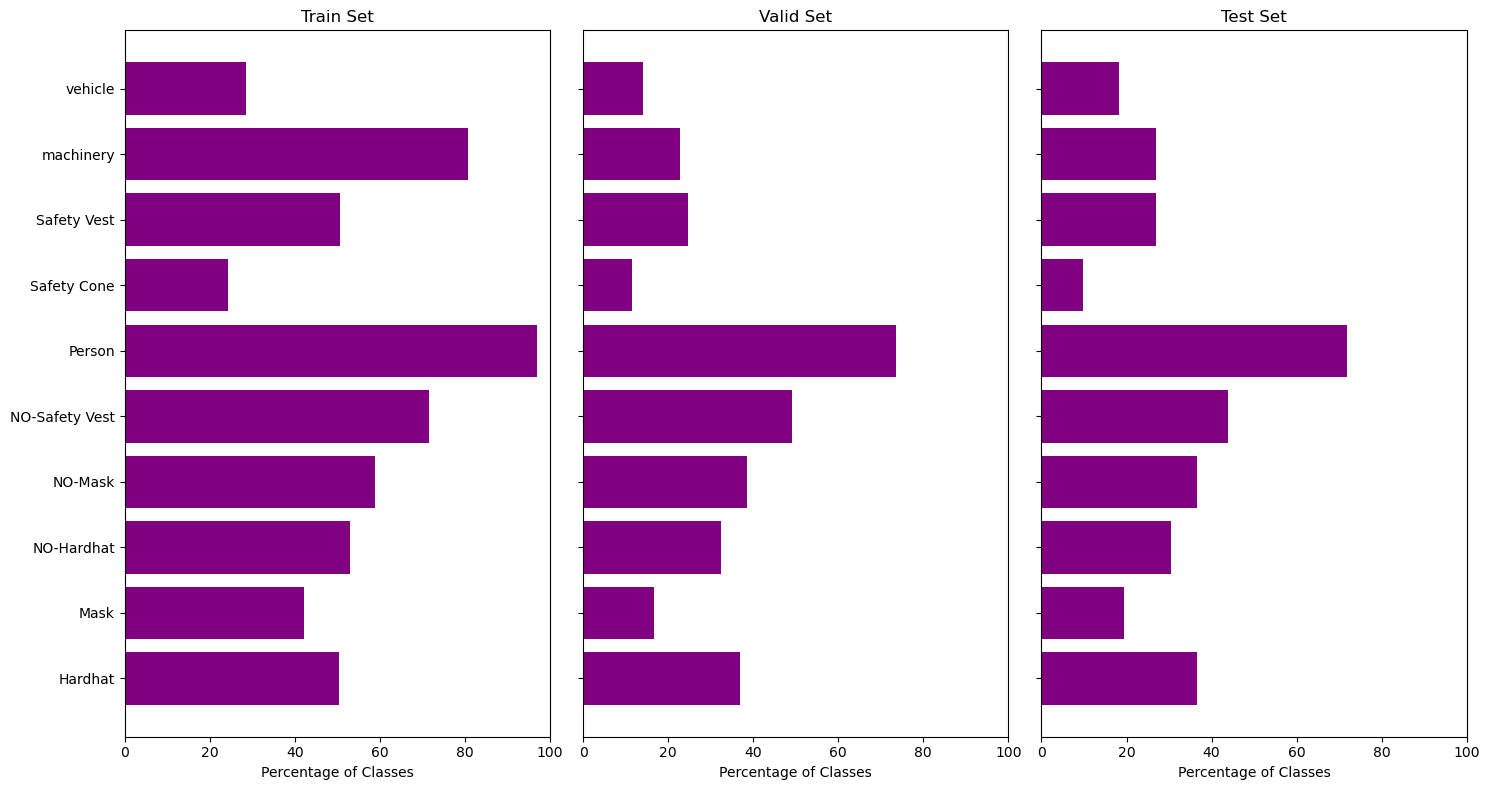

In [9]:
# Plot class distribution using horizontal bar plot (Matplotlib)
fig, ax = plt.subplots(1, 3, figsize=(15, 8), sharey=True)

for i, mode in enumerate(['train', 'valid', 'test']):
    df = pd.DataFrame({mode: class_stat[mode]})
    
    # Ensure classes with zero counts are included
    df = df.T / data_len[mode] * 100 if data_len[mode] > 0 else df.T  # Avoid division by zero
    ax[i].barh(df.columns, df.loc[mode], color='purple')
    
    ax[i].set_title(f"{mode.capitalize()} Set")
    ax[i].set_xlabel('Percentage of Classes')
    ax[i].set_xlim(0, 100)
    ax[i].set_yticks(range(num_classes))
    ax[i].set_yticklabels(classes)

plt.tight_layout()
plt.show()


In [10]:
# Print image sizes in each dataset
for mode in ['train', 'valid', 'test']:
    print(f'\n--- Image Size Summary for {mode.capitalize()} Dataset ---')
    img_size_list = []
    for file in glob.glob(os.path.join(Input_path, mode, 'images', '*')):
        image = Image.open(file)
        size_str = f"Resolution: {image.size[0]}x{image.size[1]} pixels"
        if size_str not in img_size_list:
            img_size_list.append(size_str)
            print(f' - {size_str}')



--- Image Size Summary for Train Dataset ---
 - Resolution: 640x640 pixels

--- Image Size Summary for Valid Dataset ---
 - Resolution: 640x640 pixels

--- Image Size Summary for Test Dataset ---
 - Resolution: 640x640 pixels


In [11]:
# Print the number of images in each dataset
for mode in ['train', 'valid', 'test']:
    files = glob.glob(os.path.join(Input_path, mode, 'images', '*'))
    print(f'\n--- {mode.capitalize()} Dataset ---')
    print(f'Total Images: {len(files)}')
    print('Status: Dataset is ready!' if len(files) > 0 else 'Status: Dataset is empty.')



--- Train Dataset ---
Total Images: 2605
Status: Dataset is ready!

--- Valid Dataset ---
Total Images: 114
Status: Dataset is ready!

--- Test Dataset ---
Total Images: 82
Status: Dataset is ready!


In [12]:
!pip install ultralytics
!pip install lightgbm

In [20]:
from ultralytics import YOLO
import lightgbm as lgb


# Load YOLOv8 model (pretrained on COCO dataset)
model = YOLO('yolov8n.pt')  # You can use yolov8s.pt, yolov8m.pt, etc., for larger models
model.train(data=os.path.join(Work_path,'data.yaml'),
            task='detect',
            imgsz=640,
            epochs=50,
            batch=32,
            mode='train',
            name='yolov8n_v1_train')

Ultralytics 8.3.21  Python-3.11.7 torch-2.5.0+cpu CPU (11th Gen Intel Core(TM) i5-1135G7 2.40GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=D:\second dataset\output\data.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_v1_train10, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_la

train: Scanning D:\second dataset\train\labels.cache... 2605 images, 6 backgrounds, 0 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: WARNING  D:\second dataset\train\images\004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
train: WARNING  D:\second dataset\train\images\construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed



val: Scanning D:\second dataset\valid\labels.cache... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]

Plotting labels to runs\detect\yolov8n_v1_train10\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\yolov8n_v1_train10
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G       1.39      2.976      1.485        312        640: 100%|██████████| 82/82 [15:19<00:00, 11.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:19<00:00,  9.69s/it]

                   all        114        697      0.443      0.283        0.3      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.297      1.867      1.447        271        640: 100%|██████████| 82/82 [14:42<00:00, 10.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:18<00:00,  9.21s/it]

                   all        114        697      0.508      0.411       0.41      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.246      1.667      1.414        222        640: 100%|██████████| 82/82 [15:57<00:00, 11.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:18<00:00,  9.32s/it]

                   all        114        697      0.528      0.417       0.42      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.226      1.566      1.393        201        640: 100%|██████████| 82/82 [16:03<00:00, 11.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:18<00:00,  9.01s/it]

                   all        114        697      0.598      0.452      0.467      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G        1.2      1.493       1.36        302        640: 100%|██████████| 82/82 [16:01<00:00, 11.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:18<00:00,  9.06s/it]

                   all        114        697       0.66      0.496      0.539      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.183      1.434      1.349        325        640: 100%|██████████| 82/82 [16:06<00:00, 11.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  9.00s/it]

                   all        114        697      0.668      0.482      0.536      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G       1.15      1.371      1.332        214        640: 100%|██████████| 82/82 [16:03<00:00, 11.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:18<00:00,  9.48s/it]

                   all        114        697      0.639       0.51      0.556      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.144      1.328      1.316        302        640: 100%|██████████| 82/82 [1:04:40<00:00, 47.33s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.21s/it]

                   all        114        697      0.692      0.523       0.55      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.118      1.292      1.305        317        640: 100%|██████████| 82/82 [14:52<00:00, 10.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.28s/it]

                   all        114        697       0.66      0.498      0.562      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.107      1.252      1.287        261        640: 100%|██████████| 82/82 [14:41<00:00, 10.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.48s/it]

                   all        114        697      0.763      0.545      0.623      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.103      1.207      1.282        231        640: 100%|██████████| 82/82 [14:47<00:00, 10.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.23s/it]

                   all        114        697      0.733      0.591      0.639      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.088      1.192      1.274        189        640: 100%|██████████| 82/82 [14:55<00:00, 10.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.39s/it]

                   all        114        697      0.775      0.544       0.62      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.076       1.17      1.264        231        640: 100%|██████████| 82/82 [14:57<00:00, 10.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.37s/it]

                   all        114        697      0.718      0.561       0.61      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.066      1.127      1.252        186        640: 100%|██████████| 82/82 [16:21<00:00, 11.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:18<00:00,  9.42s/it]

                   all        114        697      0.801      0.597      0.668      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.049      1.112      1.243        321        640: 100%|██████████| 82/82 [16:31<00:00, 12.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:18<00:00,  9.28s/it]

                   all        114        697      0.725      0.588      0.621      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.043       1.08      1.232        239        640: 100%|██████████| 82/82 [16:43<00:00, 12.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:18<00:00,  9.29s/it]

                   all        114        697      0.787      0.583      0.669      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.036      1.059      1.226        298        640: 100%|██████████| 82/82 [16:43<00:00, 12.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:18<00:00,  9.32s/it]

                   all        114        697      0.755       0.57      0.648      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.035      1.052      1.231        233        640: 100%|██████████| 82/82 [16:32<00:00, 12.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:18<00:00,  9.31s/it]

                   all        114        697      0.806      0.619      0.687      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.027      1.023      1.219        288        640: 100%|██████████| 82/82 [16:40<00:00, 12.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:18<00:00,  9.29s/it]

                   all        114        697       0.83      0.572      0.668      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.009      1.009      1.214        170        640: 100%|██████████| 82/82 [16:44<00:00, 12.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:18<00:00,  9.31s/it]

                   all        114        697      0.778      0.627      0.689      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      1.006     0.9926      1.207        355        640: 100%|██████████| 82/82 [16:47<00:00, 12.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:18<00:00,  9.33s/it]

                   all        114        697      0.794      0.624      0.688      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.001     0.9749      1.204        241        640: 100%|██████████| 82/82 [16:34<00:00, 12.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:18<00:00,  9.32s/it]

                   all        114        697      0.802      0.626      0.701      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G     0.9898     0.9587      1.195        281        640: 100%|██████████| 82/82 [15:31<00:00, 11.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.05s/it]

                   all        114        697      0.785      0.607      0.678      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G     0.9837     0.9496       1.19        343        640: 100%|██████████| 82/82 [14:43<00:00, 10.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.14s/it]

                   all        114        697      0.801      0.618      0.685      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G     0.9747     0.9377      1.186        297        640: 100%|██████████| 82/82 [15:23<00:00, 11.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.90s/it]

                   all        114        697      0.826       0.61      0.706      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      0.965     0.9167      1.179        292        640: 100%|██████████| 82/82 [16:08<00:00, 11.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.94s/it]

                   all        114        697      0.813      0.657      0.716      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G     0.9657     0.9108      1.178        287        640: 100%|██████████| 82/82 [16:09<00:00, 11.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.93s/it]

                   all        114        697      0.817      0.651      0.715      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G     0.9543     0.9027      1.176        220        640: 100%|██████████| 82/82 [16:10<00:00, 11.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.96s/it]

                   all        114        697      0.809      0.661      0.718      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G     0.9618       0.91      1.181        186        640: 100%|██████████| 82/82 [16:09<00:00, 11.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.94s/it]

                   all        114        697      0.799      0.617      0.697      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G     0.9337     0.8733      1.162        352        640: 100%|██████████| 82/82 [16:11<00:00, 11.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.90s/it]

                   all        114        697      0.815      0.652       0.72      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G     0.9379     0.8705      1.158        211        640: 100%|██████████| 82/82 [16:03<00:00, 11.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.89s/it]

                   all        114        697      0.837      0.656      0.732      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G     0.9348     0.8591      1.157        453        640: 100%|██████████| 82/82 [16:04<00:00, 11.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.86s/it]

                   all        114        697      0.838      0.681      0.753      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G     0.9106     0.8431      1.146        310        640: 100%|██████████| 82/82 [15:58<00:00, 11.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.84s/it]

                   all        114        697      0.838       0.65      0.731      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G     0.9212     0.8466      1.147        253        640: 100%|██████████| 82/82 [16:14<00:00, 11.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.85s/it]

                   all        114        697      0.874      0.646       0.75      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G     0.9093     0.8308      1.144        234        640: 100%|██████████| 82/82 [16:04<00:00, 11.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.81s/it]

                   all        114        697       0.88      0.662      0.754      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G     0.9048     0.8165       1.14        261        640: 100%|██████████| 82/82 [16:04<00:00, 11.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.90s/it]

                   all        114        697      0.843      0.681      0.742       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G     0.8976     0.8047      1.135        371        640: 100%|██████████| 82/82 [16:00<00:00, 11.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.88s/it]

                   all        114        697      0.852      0.675      0.749      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G     0.8864     0.7955      1.126        254        640: 100%|██████████| 82/82 [15:54<00:00, 11.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.16s/it]

                   all        114        697      0.892      0.665       0.75      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G     0.8813     0.7968      1.126        362        640: 100%|██████████| 82/82 [14:34<00:00, 10.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.10s/it]

                   all        114        697      0.872       0.68      0.756      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G     0.8717     0.7793      1.118        308        640: 100%|██████████| 82/82 [14:36<00:00, 10.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.07s/it]

                   all        114        697      0.875      0.676      0.761      0.441


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G     0.9036     0.7367      1.143        131        640: 100%|██████████| 82/82 [14:08<00:00, 10.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.06s/it]

                   all        114        697      0.885      0.674       0.76      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G     0.8765      0.687       1.12        221        640: 100%|██████████| 82/82 [14:26<00:00, 10.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.08s/it]

                   all        114        697      0.875      0.686      0.764      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G     0.8663     0.6804      1.116        206        640: 100%|██████████| 82/82 [14:08<00:00, 10.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.03s/it]

                   all        114        697      0.913      0.668       0.76      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G      0.864     0.6746       1.11        211        640: 100%|██████████| 82/82 [14:10<00:00, 10.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.06s/it]

                   all        114        697       0.86      0.705      0.769      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G      0.851      0.661      1.103        182        640: 100%|██████████| 82/82 [14:30<00:00, 10.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.88s/it]

                   all        114        697      0.816      0.711      0.761      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G       0.85     0.6577      1.106        221        640: 100%|██████████| 82/82 [15:29<00:00, 11.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.84s/it]

                   all        114        697       0.85       0.71      0.778       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G     0.8347     0.6478      1.104        122        640: 100%|██████████| 82/82 [15:26<00:00, 11.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.86s/it]

                   all        114        697      0.891      0.688      0.777      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G     0.8268     0.6423      1.093        159        640: 100%|██████████| 82/82 [15:28<00:00, 11.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.86s/it]

                   all        114        697      0.889      0.697      0.782      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G     0.8221     0.6343      1.088        152        640: 100%|██████████| 82/82 [15:32<00:00, 11.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.89s/it]

                   all        114        697      0.894      0.689      0.781      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G     0.8134     0.6233      1.082        143        640: 100%|██████████| 82/82 [15:31<00:00, 11.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.88s/it]

                   all        114        697      0.899      0.697      0.785      0.472



50 epochs completed in 14.118 hours.
Optimizer stripped from runs\detect\yolov8n_v1_train10\weights\last.pt, 6.3MB
Optimizer stripped from runs\detect\yolov8n_v1_train10\weights\best.pt, 6.3MB

Validating runs\detect\yolov8n_v1_train10\weights\best.pt...
Ultralytics 8.3.21  Python-3.11.7 torch-2.5.0+cpu CPU (11th Gen Intel Core(TM) i5-1135G7 2.40GHz)
Model summary (fused): 168 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.74s/it]


                   all        114        697      0.888      0.697      0.782      0.476
               Hardhat         42         79      0.982      0.734      0.876      0.567
                  Mask         19         21          1      0.874       0.93      0.655
            NO-Hardhat         37         69      0.929      0.571       0.69      0.348
               NO-Mask         44         74      0.937      0.527      0.623       0.32
        NO-Safety Vest         56        106      0.905      0.627      0.754      0.416
                Person         84        166      0.906      0.729      0.818      0.504
           Safety Cone         13         44      0.816      0.804       0.84      0.429
           Safety Vest         28         41        0.9       0.78      0.881       0.57
             machinery         26         55      0.892      0.891      0.932      0.637
               vehicle         16         42      0.615      0.429      0.478      0.312
Speed: 2.9ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000273E0A19A10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,   

In [21]:
results = model.predict(source=os.path.join(Input_path, 'test', 'images'), save=True)


image 1/82 D:\second dataset\test\images\-4405-_png_jpg.rf.82b5c10b2acd1cfaa24259ada8e599fe.jpg: 640x640 1 Hardhat, 3 NO-Safety Vests, 2 Persons, 344.4ms
image 2/82 D:\second dataset\test\images\000005_jpg.rf.96e9379ccae638140c4a90fc4b700a2b.jpg: 640x640 2 Hardhats, 2 NO-Masks, 2 Persons, 72.4ms
image 3/82 D:\second dataset\test\images\002551_jpg.rf.ce4b9f934161faa72c80dc6898d37b2d.jpg: 640x640 2 Hardhats, 2 NO-Masks, 2 NO-Safety Vests, 4 Persons, 76.3ms
image 4/82 D:\second dataset\test\images\003357_jpg.rf.9867f91e88089bb68dc95947d5116d14.jpg: 640x640 1 Hardhat, 1 NO-Mask, 2 NO-Safety Vests, 1 Person, 1 Safety Cone, 71.8ms
image 5/82 D:\second dataset\test\images\004063_jpg.rf.1b7cdc4035bcb24ef69b8798b444053e.jpg: 640x640 5 Hardhats, 5 NO-Safety Vests, 6 Persons, 1 Safety Vest, 77.6ms
image 6/82 D:\second dataset\test\images\004763_jpg.rf.46484e6ca73caeaa9de45822cf1085a9.jpg: 640x640 3 Hardhats, 2 NO-Masks, 3 NO-Safety Vests, 3 Persons, 75.4ms
image 7/82 D:\second dataset\test\image